# 1. Data Preparation

/tmp/ipykernel_108102/4137815043.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_108102/4137815043.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)


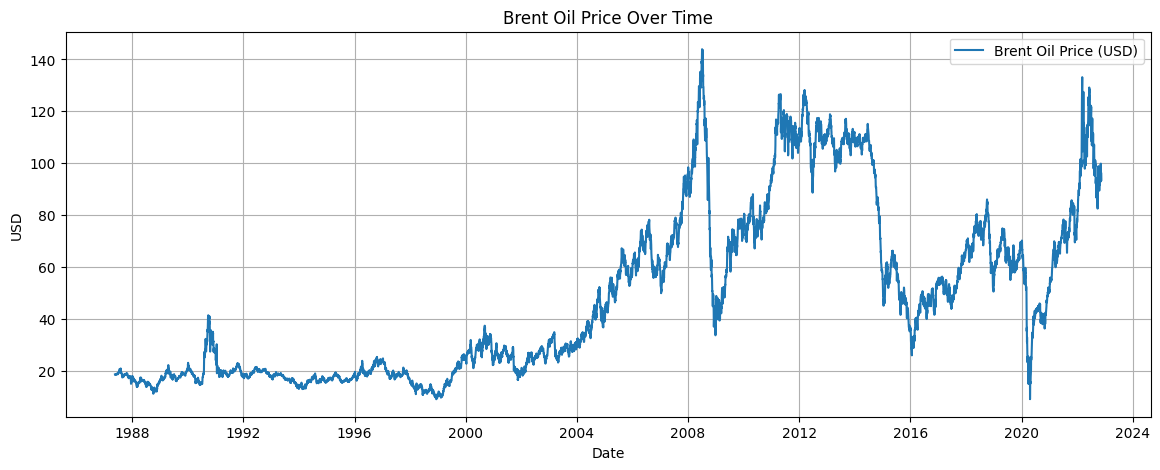

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Brent oil data
df = pd.read_csv('../data/raw/BrentOilPrices.csv')
df.columns = ['date', 'price']

# Convert date safely with mixed/inferred formats
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)

# Remove rows with invalid dates or non-positive prices
df = df.dropna(subset=['date'])
df = df[df['price'] > 0].copy()

# Sort and reset index
df = df.sort_values('date').reset_index(drop=True)

# Plot price
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['price'], label='Brent Oil Price (USD)')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.legend()
plt.show()


# 2. Convert to Log Returns

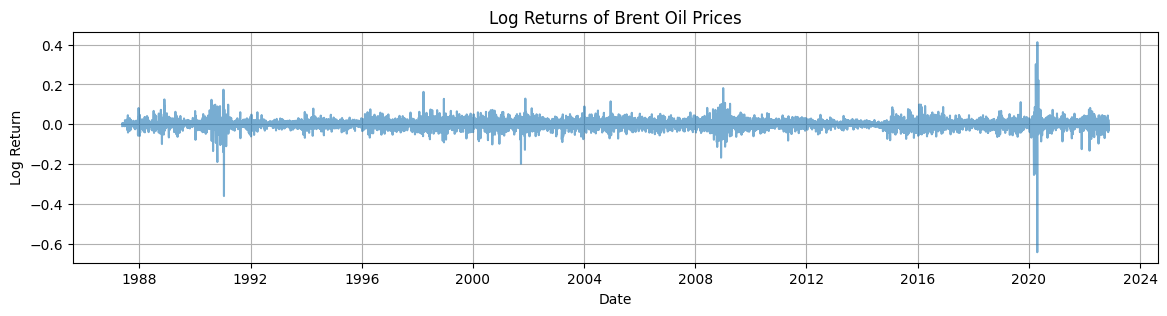

In [6]:
df['log_price'] = np.log(df['price'])
df['log_return'] = df['log_price'].diff()

# Drop NA
df.dropna(inplace=True)

# Plot log returns
plt.figure(figsize=(14, 3))
plt.plot(df['date'], df['log_return'], alpha=0.6)
plt.title('Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()


# 3. Build the Bayesian Change Point Model (PyMC3)

In [8]:
import pymc as pm
import arviz as az


# Use a smaller sample for speed during testing (optional)
log_returns = df['log_return'].values[-2000:]  # You can use full series later
n = len(log_returns)

with pm.Model() as model:
    # Prior on change point index (tau)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)

    # Priors on the mean before and after
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Priors on the standard deviations before and after
    sigma1 = pm.HalfNormal('sigma1', sigma=1)
    sigma2 = pm.HalfNormal('sigma2', sigma=1)

    # Switch the mean and sigma at change point
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    sigma = pm.math.switch(tau >= np.arange(n), sigma1, sigma2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Sample from posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)
    print("done")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


done


# 4. Interpret the Model Output

##  A. Check Model Convergence

In [9]:
# Summary statistics
az.summary(trace, round_to=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1262.5571,77.1355,1165.0000,1317.0000,32.3931,17.0147,6.9571,23.7070,1.5591
mu1,0.0001,0.0006,-0.0011,0.0013,0.0000,0.0000,7639.2529,5795.1151,1.0037
mu2,0.0007,0.0018,-0.0028,0.0038,0.0000,0.0000,6893.7884,5337.6457,1.0031
sigma1,0.0225,0.0005,0.0216,0.0233,0.0000,0.0000,4727.8520,3972.9235,1.0050
sigma2,0.0474,0.0022,0.0431,0.0512,0.0008,0.0003,8.3870,33.3517,1.3959


## B. Trace Plots

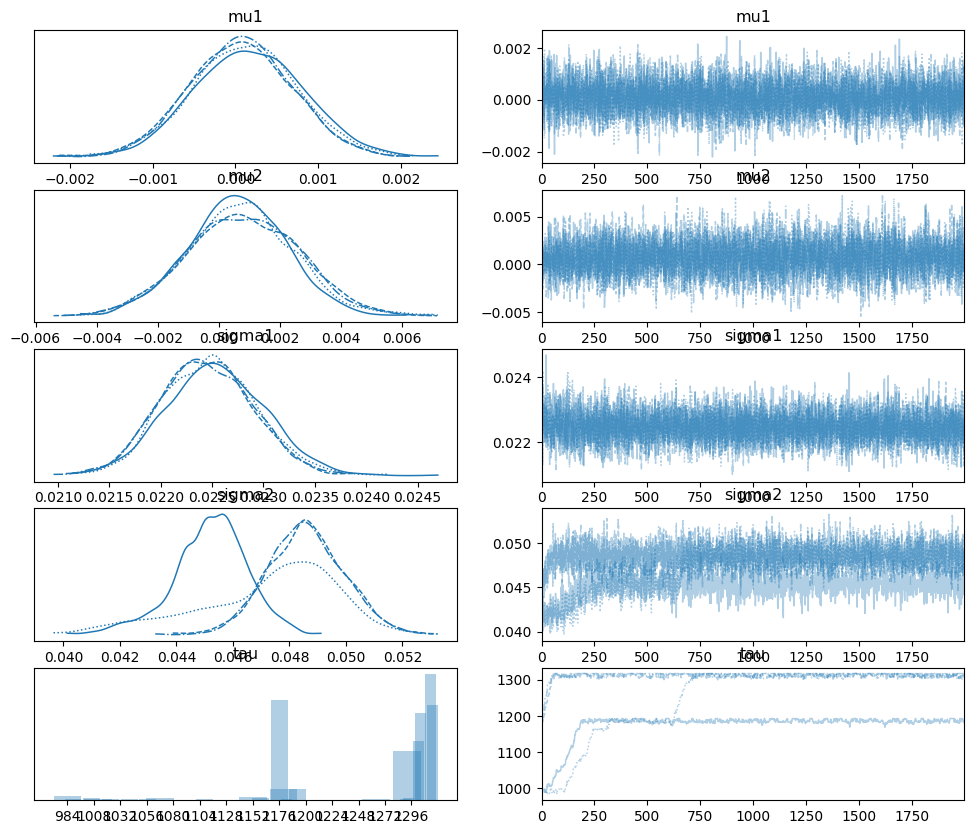

In [10]:
az.plot_trace(trace, var_names=['mu1', 'mu2', 'sigma1', 'sigma2', 'tau'])
plt.show()


## C. Change Point Date


In [12]:
# Get MAP estimate (most probable change point)
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.round(np.median(tau_samples)))
change_date = df['date'].iloc[-2000 + most_likely_tau]

print(f"📍 Most likely change point at index: {most_likely_tau}")
print(f"📅 Corresponding date: {change_date.date()}")


📍 Most likely change point at index: 1309
📅 Corresponding date: 2020-02-24


## D. Visualize Change Point

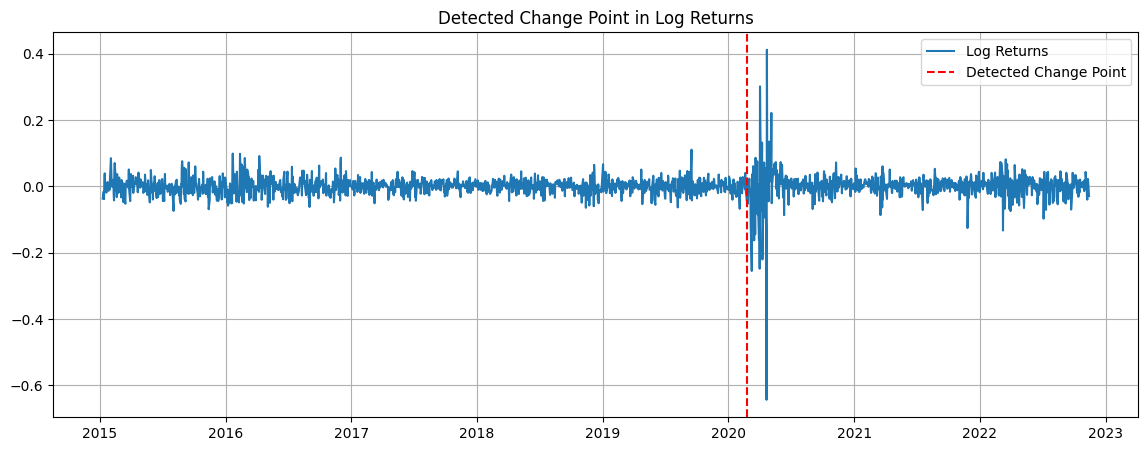

In [13]:
plt.figure(figsize=(14, 5))
plt.plot(df['date'].iloc[-2000:], log_returns, label='Log Returns')
plt.axvline(x=change_date, color='red', linestyle='--', label='Detected Change Point')
plt.title('Detected Change Point in Log Returns')
plt.legend()
plt.grid(True)
plt.show()


# 5. Match Change Point to External Events

In [17]:
event_df = pd.read_csv('../data/raw/events.csv')
print(event_df.columns)


Index(['Date', 'Event Name', 'Description', 'Category'], dtype='object')


In [19]:
event_df = pd.read_csv('../data/raw/events.csv', parse_dates=['Date'])
print(event_df.head())


        Date                            Event Name  \
0 2012-01-23        EU imposes oil embargo on Iran   
1 2014-06-01  ISIS captures key oil fields in Iraq   
2 2014-11-27  OPEC decides against production cuts   
3 2015-12-04       OPEC abandons production quotas   
4 2016-11-30         OPEC agrees to cut production   

                                         Description               Category  
0  EU imposes oil embargo on Iran over nuclear pr...      Economic Sanction  
1               ISIS captures key oil fields in Iraq  Geopolitical Conflict  
2  OPEC decides against production cuts, leading ...            OPEC Policy  
3  OPEC abandons production quotas, increasing su...            OPEC Policy  
4  OPEC agrees to cut production by 1.2 million b...            OPEC Policy  


In [20]:
event_df['days_diff'] = (event_df['Date'] - change_date).dt.days.abs()
close_events = event_df[event_df['days_diff'] < 90]  # Events within 90 days
close_events.sort_values('days_diff')


,Date,Event Name,Description,Category,days_diff
7,2020-03-06,OPEC+ fails to agree on production cuts,OPEC+ fails to agree on production cuts; Saudi...,OPEC Policy,11
8,2020-04-02,COVID-19 demand collapse impacts Brent crude,Brent crude falls to $29.69 due to COVID-19 de...,Global Economic Shock,38
9,2020-04-12,OPEC+ agrees to record production cut,OPEC+ agrees to record production cut of 9.7 m...,OPEC Policy,48


# 6. Quantify the Impact

In [21]:
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()

# Posterior mean difference
mean_mu1 = np.mean(mu1_samples)
mean_mu2 = np.mean(mu2_samples)
percent_change = (np.exp(mean_mu2) - np.exp(mean_mu1)) * 100

print(f"Mean return before: {mean_mu1:.5f}")
print(f"Mean return after: {mean_mu2:.5f}")
print(f"Estimated change in average return: {percent_change:.2f}%")


Mean return before: 0.00010
Mean return after: 0.00073
Estimated change in average return: 0.06%
